# 自己組織化マップ（SOM)＆クラスタリング

自己組織化マップのわかり易い例として、入力をRGB３原色の組とし、色データを２次元空間にマッピングするという例がある。

個々のカラーデータは３つの成分を持つので３次元空間に分布するデータなわけだが、それを２次元に配置するということは１次元分次元を圧縮することになる。

たとえば、[勝手に整理整頓 ─ 自動分類アルゴリズム](http://gaya.jp/spiking_neuron/som.htm) がすごくわかりやすい。

この例を取り上げているサイトはたくさんあって、たいていはひたすらランダムに３原色を発生させてマップを更新するというプログラムになっている。

次元圧縮という意味では、最終的にあらゆる色をマッピングしないといけないのだから、それでいいわけなのだけど、通常自己組織化マップをつくる時はランダムにあらゆるデータを生成するのではなく、実際に観測された多次元データを２次元にマッピングしてああだこうだと解析するのに使うわけで、無限に（実際にはデジタルの色は有限だが）色を発生させて組織化するというのはなんか違う、という気がする。

そこで、このプログラムではランダムに色を発生させるのではなく、実際の画像に使われている色をランダムにピックアップして使うという風にしてみた。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
% matplotlib notebook
import urllib.request
import io
import PIL.Image
import cv2

# ネット上の画像を取ってくるメソッド
def url2img(url):
    print(url)
    f = io.BytesIO(urllib.request.urlopen(url).read())
    img = PIL.Image.open(f)
    imgArray = np.asarray(img)
    return imgArray

# 画像から　色を　num 個ピックアップするメソッド
def pickcolor(imgArray, num):
    w = imgArray.shape[1]
    h = imgArray.shape[0]
    ret = []
    for i in range(num):
        rw = int(w*np.random.rand())
        rh = int(h*np.random.rand())
        ret.append(imgArray[rh,rw]/255)
    return ret

In [2]:
# 自己組織化マップ SOM を生成する　　　　M :２次元配置されたニューロンの重み配列    x : 入力データ,  alpha：学習係数
def organize_som(M, x, alpha=0.3):
    mini, minj = get_winner(M,x)
    for i in range(-2,3): #  勝者の近傍5x5 の範囲を与えられたデータ（このプログラムでは色）に近づける
        for j in range(-2,3):
            try:
                M[mini+i,minj+j] += alpha * (x - M[mini+i,minj+j])/(abs(i)+abs(j)+1)
            except:
                pass
    return M

# Map M において、ベクトルｘともっとも近い重みベクトルを持つノードの座標を得る
def get_winner(M,x):
    col =  M.shape[1]
    # row =  M.shape[0]
    min_i = np.argmin(((M-x)**2).sum(axis=2)) 
    mini = min_i // col # argmin は1次元化した番号が返ってくるので　2次元化
    minj = min_i % col
    return mini, minj

# 配列３次元M（ただし最後の次元は３要素でありカラーデータとみなせるもの）を matplot 画像データとして返す
def show_som(M):
    im = plt.imshow(M,interpolation='none')
    return im

ウェブ上の画像をカラーデータの採取用に読み込む

http://cityregendxxx.com/img/snapcrab_noname_2016-7-18_23-33-33_no-00.jpg


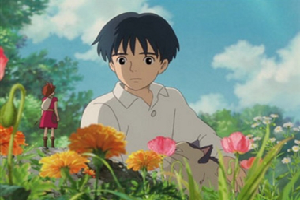

In [3]:
imgArray = url2img("http://cityregendxxx.com/img/snapcrab_noname_2016-7-18_23-33-33_no-00.jpg")
PIL.Image.fromarray(imgArray).resize((300,200))

<IPython.core.display.Javascript object>


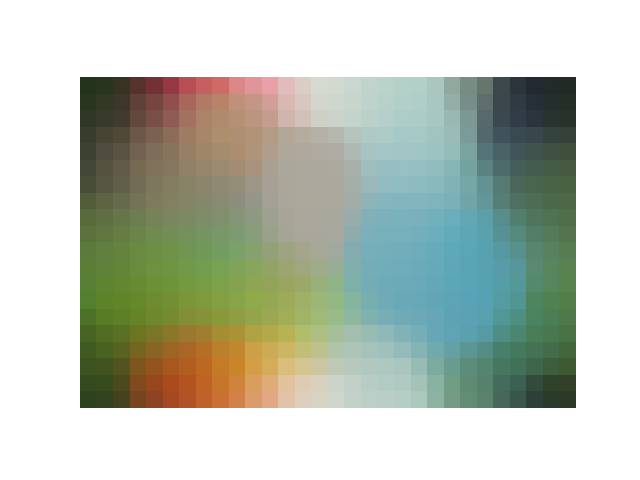

In [4]:
# メインプログラム
row = 20  # 高さ
col = 30 # 幅
learntime = 256 # 繰り返し学習回数
batchsize = 128 # １回の繰り返しで採取するデータの数
alpha = 0.3 # 学習係数

W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    colors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in colors:
            organize_som(W, color) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()

このマップは20ｘ30個のRGBのデータ集合だと考えられる。この600個のデータをK-Means法でクラスタリングしてみよう。

いま、Wは20ｘ30の行列表現されているが、これを　600個のデータ列に変換しないといけない。

In [5]:
from sklearn.cluster import KMeans

def kmeans(M,k,itr):   # 配列Mの要素を対象として k-Means 法でクラスタリングを実行する　　k クラスタ数、 itr 繰り返し処理回数
    row = M.shape[0]
    col = M.shape[1]
    ch = M.shape[2]
    data = M.reshape(col*row,ch)
    km = KMeans(n_clusters=k,init='random',n_init=1,max_iter=itr,random_state=1)
    labelimage = (km.fit(data).labels_).reshape(row,col)
    centers = km.cluster_centers_
    return labelimage, centers 

from matplotlib.colors import LinearSegmentedColormap
# カスタムカラーマップの生成
def generate_cmap(centers):
    lebels = len(centers)
    values = range(lebels)
    color_list = centers # ３次元データの重心の値そのものをカラーデータとみなす
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

In [6]:
# 境界の描画
def plotBoundary(labels, mesh=True, boundary=True, n_neighbors=1, cmap='tab20'):
    row = labels.shape[0]
    col = labels.shape[1]
    
    YY,XX = np.mgrid[row-1:-1:-1, 0:col] # make a grid    
    #  matplotlib  の  plot   は　X 、Yの並びなので numpy 配列を転地しないといけない   

    if mesh:
        plt.pcolormesh(XX, YY, labels, cmap=cmap,zorder=-10) 
        plt.colorbar()

    if boundary:
        plt.contour(XX, YY, Z, 
                    colors='k', linestyles='-', levels=[1])

In [7]:
# 代表色１０色
labelimage, centers = kmeans(W,10,100)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, mesh=True, boundary=False, n_neighbors=2,cmap=custom_cmap)

In [8]:
# 代表色１５色
labelimage, centers =  kmeans(W,15,100)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, mesh=True, boundary=False, n_neighbors=2,cmap=custom_cmap)

<IPython.core.display.Javascript object>


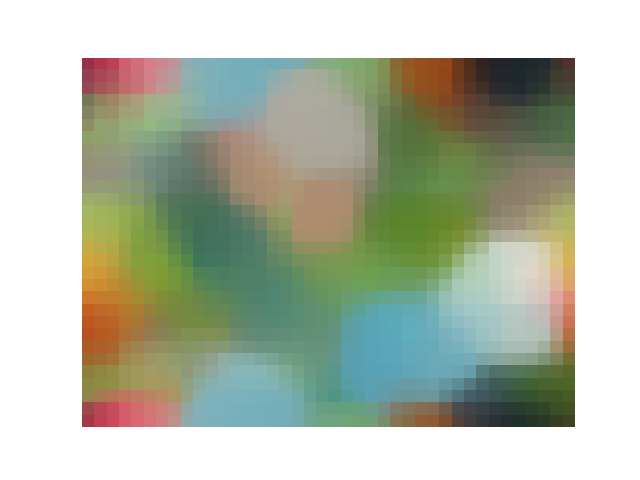

In [9]:
# 少しメッシュを細かくして動画を生成してみる
row = 30
col =40
learntime = 256
batchsize = 128
alpha = 0.3

W = np.random.random([row,col,3])

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    colors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in colors:
            organize_som(W, color)
    ims.append([show_som(W)])
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
ani.save("som.mp4")  # ffmpeg がインストールされていないと動かない
plt.show()

参考

- [SOM（自己組織化写像）のプログラム (python)](http://swdrsker.hatenablog.com/entry/2016/12/08/171356) を小サイズ化したプログラム
- [ffmpeg DOWNLOAD](http://www.ffmpegmac.net/)